In [19]:
import os
import re
import csv
import pandas as pd
import math as m
import numpy as np
import linecache
import string
import matplotlib.pylab as plt
import datetime
import random
import seaborn as sns
from tqdm import tqdm
import matplotlib
from collections import defaultdict

## Data

In [2]:
df = pd.read_csv('wikigraph_reduced.csv')

In [3]:
df = df['\t0\t1'].str.split('\t', n=2, expand = True)
df.rename(columns={0: "edge",1: "source", 2: "target"}, inplace = True)
df.head(10)

,edge,source,target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222
5,1143,134,1061485
6,1146,134,1163610
7,1147,134,1163783
8,1309,153,744272
9,1311,153,1064807


In [4]:
pages = pd.read_csv('wiki-topcats-page-names.txt', header = None, names = ['page'])
pages = pages['page'].str.split(' ', n=1, expand = True)
pages.drop(0,axis=1, inplace = True)
pages.rename(columns={1:'pageName'},inplace=True)

In [5]:
pages.head()

,pageName
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem


In [2]:
file = open("wiki-topcats-categories.txt", "r")
contents = file.read()
contents = contents.split("\n")
file.close()

'Category:Buprestoidea; 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 

## Initial Anlysis

In [3]:
#dictionary that has for keys the category and for value the list of pages in that category
dictionary_cat = {}

for i in tqdm(range(len(contents))):
    
    temp = contents[i].split(";")    
    if len(temp)>1:
    
        key = temp[0]
        key = key[9::]
        key

        list_page_frcat = temp[1].split(" ")
        list_page_frcat = list_page_frcat[1::]
        list_page_frcat

        dictionary_cat[key] = list_page_frcat

100%|██████████| 17365/17365 [00:00<00:00, 28663.63it/s]


In [4]:
#dictionary that associates to each page, the list of categories that is in
inverted_link = {}

for i in tqdm(range (len(contents))):
    
    temp = contents[i].split(";")  
    if len(temp)>1:
        key = temp[0]
        key = key[9::]
        key

        list_page_frcat = temp[1].split(" ")
        list_page_frcat = list_page_frcat[1::]
        list_page_frcat

        for x in list_page_frcat: 

            if x not in inverted_link.keys():             
                inverted_link[x] = []
                inverted_link[x].append(key)

            else:
                 inverted_link[x].append(key)

100%|██████████| 17365/17365 [00:05<00:00, 3195.32it/s]


In [92]:
#list that has all the pages that have are associated to more than 1 category
key_list = []
for key in inverted_link.keys():
    if len(inverted_link[key])>1:
        key_list.append(key)
print(f'number of pages that appear in more than one category: {len(key_list)}')

number of pages that appear in more than one category: 977014


In [8]:
inverted_link["303"]

['Buprestoidea', 'Insect_families']

In [12]:
#dictionary that shows the distribution of the pages in each category
len_list = {}

for key in key_list:     
    lenght = len(inverted_link[key]) 
    
    if lenght not in len_list.keys():             
                len_list[lenght] = 1
    else:
        len_list[lenght] += 1

In [141]:
len_list

{2: 349893,
 4: 132517,
 3: 211504,
 6: 60167,
 7: 40023,
 12: 6738,
 9: 18802,
 11: 9379,
 13: 4912,
 5: 89085,
 8: 27118,
 14: 3626,
 10: 13315,
 16: 1967,
 18: 1051,
 19: 724,
 15: 2635,
 22: 277,
 21: 392,
 17: 1471,
 27: 63,
 20: 577,
 23: 250,
 24: 156,
 26: 97,
 25: 109,
 30: 23,
 32: 11,
 28: 44,
 29: 35,
 36: 3,
 31: 23,
 38: 3,
 33: 8,
 34: 9,
 35: 3,
 134: 1,
 37: 1,
 39: 1,
 48: 1}

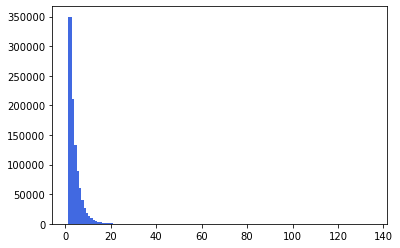

In [132]:
plt.bar(len_list.keys(), len_list.values(), width = 2.0, color='royalblue')
plt.xlim = (0, 1.05*max(len_list.keys()))

For every page in the inverted index (key) I uniformly choose at random the category in which belongs and I create a new dictionary where the categories are the keys and the pages in each category are the values.

In [77]:
#final dictionary where the pages that appear in multiple categories are assigned to only one uniformly at random
final_category_dict = dict.fromkeys(dictionary_cat.keys())

for key,value in tqdm(inverted_link.items()):
    category = str(*np.random.choice(value, size=1, replace=False, p= None))
    if final_category_dict[category] == None:
        final_category_dict[category] = [key]
    else:
        final_category_dict[category].append(key)    

100%|██████████| 1791490/1791490 [00:35<00:00, 51099.82it/s]


#### Trial to see if the above operation worked

In [85]:
#dictionary that associates to each page, the list of categories that it is in
inverted_link2 = {}

for key,value in tqdm(final_category_dict.items()):
    if value != None:

        for elem in value: 
            if elem not in inverted_link2.keys():             
                inverted_link2[elem] = []
                inverted_link2[elem].append(key)

            else:
                inverted_link2[elem].append(key)

100%|██████████| 17364/17364 [00:02<00:00, 7337.27it/s]


In [89]:
key_list = []
for key in inverted_link2.keys():
    if len(inverted_link2[key])>1:
        key_list.append(key)
key_list

[]

This proves that now there are no pages that appear in multiple categories

### RQ1. Build the graph G=(V, E)
Provide its basic information:

- Is the graph directed?
- How many articles are we considering?
- How many hyperlinks between pages exist?
- Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?
- Visualize the nodes' degree distribution

### RQ2. Function 1

Define a function that takes in input:

- A page *v*
- A number of clicks *d*

and returns the set of all pages that a user can reach within *d* clicks.

### RQ3. Function 2

Define a function that takes in input:

- A category *C*
- A set of pages in *C*, *p = {p1, ..., pn}*

and returns the minimum number of clicks required to reach all pages in *p*, starting from the page *v*, corresponding to the most central article, according to the *in-degree* centrality, in *C*.

### RQ4. Induced Subgraph

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

- Let *v* and *u* two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect *u* and *v*?

### RQ5. Function 3

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as  $distance(C0, Ci) = median(ShortestPath(C0, Ci))$ 

Where $ShortestPath(C0, Ci)$ is the set of shortest paths from each pair of nodes in the two categories.

### RQ6. Function 4

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm